## **CS235 Project Part 2**


### Kelsey Musolf


#### SID: 862191249

*****************************************************
## **Part 1 Hyperparameter Optimization [30%]**

Deciding which is the best combination of hyperparameter values for a given downstream task
and dataset is a critical part of data science pipelines. Different types of hyperparameter
optimization essentially boil down to systematically searching the space of hyperparameters
looking for a combination that maximizes the performance target. 

Here we are going to experiment with two different approaches: 
(a) Grid search, where we search linearly search the
space of hyperparameters
(b) Bayesian Optimization, where we attempt to optimize the
order in which we evaluate different points in the space of hyperparameters in hopes of
minimizing the number of evaluations that are necessary. 

For the purposes of this question, you can use Scikit-learn’s ‘GridSearchCV’ function for 
grid search and ‘BayesSearchCV’ from scikit-optimize (https://scikit-optimize.github.io/stable/) 
for Bayesian Optimization. 

The model you should optimize is a Random Forest, with all of its hyperparameters as defined in
Scikit-learn. You will compare the effectiveness of each approach in arriving at a
high-performing combination of hyperparameters and the efficiency trade-off that is being
introduced.

What to plot: A single figure that shows the best performance (F1 score) achieved by each
hyperparameter optimization method (a and b) on the y-axis versus the time spent by each
optimization method. Average out your time measurements over 5 independent runs.

*****************************************************

### Model: Random Forest
The Random Forest model is a model that takes multiple decision trees with different questions to create the same classiifications and ultimately, pick the best one. Using Hyperparameters is going to help us with this model by pruning the tree in different locations to create an optimized model that accuratly predicts the diagnosis column from our dataset. 

### A. Grid Search

A linear search for all options of hyperparameters, this brute force method will take longer to compute. First I set up my space for computing the grid search on the Wisconsin Diagnosis - Breast Cancer (WDBC) dataset. 

In [4]:
import sys
print(sys.executable)

/opt/anaconda3/envs/pytorch_env/bin/python


In [5]:
#inport all my libraries needed

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

from skopt import BayesSearchCV
#from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE

import time

In [6]:
#loading data and splitting into test and train. 

df = pd.read_csv('wdbc.data', header=None)

#drop ID column - all unique values, will skew results
df = df.drop(columns=[0])

#change diagnosis to numbers: M=1, B=0
df[1] = df[1].map({'M': 1, 'B': 0})

#features and labels
X = df.drop(columns=[1])
y = df[1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Finished with the test and training sections of data. this will be used for both sections of part 2.1, the grid search and the bayes search. 

I will now evaluate two grid search strategies for Random Forest classifier:

- **Fine Grid**: Includes a wider and denser set of values for most hyperparameters.
- **Coarse Grid**: Contains a minimal, representative subset of hyperparameters.

The fine grid explores more thoroughly but takes longer, while the coarse grid is faster but risks missing optimal combinations. The parameter sets I chose were based on website with information on Scikit-learn RandomForest. These choices are listed below:


Note: The fine grid search takes so much time that I will decrease the parameters. Running it 5 times, the first run took 57 minutes. Due to shortage on time, fewer parameters will help speed up the time. 

Starting with parameters: 

fine_grid = {
    'n_estimators': [100, 300, 500, 700, 1000],
    'max_depth': [5, 10, 15, 20, None],
    'max_features': ['sqrt', 'log2', None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}

I will shorten it to be 
fine_grid = {
    'n_estimators': [50, 100, 500, 1000],        
    'max_depth': [5, 10, None],                 
    'max_features': ['sqrt', None],       
    'min_samples_split': [2, 5, 10],            
    'min_samples_leaf': [1, 2, 4],           
    'bootstrap': [True],                 
    'criterion': ['gini']                  
}

In [19]:
fine_grid = {
    'n_estimators': [50, 100, 500, 1000],        
    'max_depth': [5, 10, None],                 
    'max_features': ['sqrt', None],       
    'min_samples_split': [2, 5, 10],            
    'min_samples_leaf': [1, 2, 4],           
    'bootstrap': [True],                 
    'criterion': ['gini']                  
}

coarse_grid = {
    'n_estimators': [100, 1000],
    'max_depth': [5, None],
    'max_features': ['sqrt'],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'bootstrap': [True],
    'criterion': ['gini']
}

I now need to run the analysis for F1 score, averaging the 5 runs per gid type. I will store these in results.

In [20]:
results = {
    'fine': {'f1_scores': [], 'times': []},
    'coarse': {'f1_scores': [], 'times': []}
}

In [21]:
#loop for both grid types
for grid_type, grid_def in [('fine', fine_grid), ('coarse', coarse_grid)]:
    print(f"Running grid search for: {grid_type} grid")
    for seed in range(5):
        #need dif train/test split/run
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=seed
        )
        
        #state model and parametes using
        model = RandomForestClassifier(random_state=42)
        grid = GridSearchCV(
            estimator=model,
            param_grid=grid_def,
            scoring='f1',
            cv=5,
            n_jobs=-1,
            verbose=0
        )
        
        #track time for plotting
        start_time = time.time()
        grid.fit(X_train, y_train)
        elapsed = time.time() - start_time
        
        #store to results
        results[grid_type]['f1_scores'].append(grid.best_score_)
        results[grid_type]['times'].append(elapsed)
        print(f"Run {seed + 1}/5 for {grid_type} grid completed")

Running grid search for: fine grid
Run 1/5 for fine grid completed
Run 2/5 for fine grid completed
Run 3/5 for fine grid completed
Run 4/5 for fine grid completed
Run 5/5 for fine grid completed
Running grid search for: coarse grid
Run 1/5 for coarse grid completed
Run 2/5 for coarse grid completed
Run 3/5 for coarse grid completed
Run 4/5 for coarse grid completed
Run 5/5 for coarse grid completed


Now need to plot these. Will do so later with bayesian search. 

### B. Bayesian Optimization

Now that the grid search method has completed (and taken a ton of time), we will speed it up with the use of Bayesian Search. This is much faster because it does not iteratively try every possible combination. Instead, when it finds something that has low error, it follows that path and tries to further improve it. 

In [28]:
#add bayesian search to my results 
results['bayes'] = {'f1_scores': [], 'times': []}

#bayes search space (same as fine_grid )
from skopt.space import Integer, Categorical


#parameters:
bayes_space = {
    'n_estimators': Integer(100, 1000),
    'max_depth': Integer(5, 20),
    'max_features': Categorical(['sqrt', None]),
    'min_samples_split': Integer(2, 4),
    'min_samples_leaf': Integer(1, 2),
    'bootstrap': Categorical([True]),
    'criterion': Categorical(['gini']),
}



Now that paramters are set, I must run this 5 times to get the average F1 score. 

In [29]:

#now to run 5 times
print("Running BayesSearchCV...")
for seed in range(5):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=seed
    )

    #model type and parameters
    model = RandomForestClassifier(random_state=42)
    bayes = BayesSearchCV(
        estimator=model,
        search_spaces=bayes_space,
        scoring='f1',
        n_iter=25,  # adjust based on compute time
        cv=5,
        n_jobs=-1,
        random_state=seed,
        verbose=0
    )

#track time for plotting
    start_time = time.time()
    bayes.fit(X_train, y_train)
    elapsed = time.time() - start_time

    #save to results
    results['bayes']['f1_scores'].append(bayes.best_score_)
    results['bayes']['times'].append(elapsed)
    print(f"Bayes run {seed + 1}/5 completed")

Running BayesSearchCV...
Bayes run 1/5 completed
Bayes run 2/5 completed
Bayes run 3/5 completed
Bayes run 4/5 completed
Bayes run 5/5 completed


After finding the best tree in the random forest 5 times for each method - I now compare then in a graph showing the best cross-validation accuracy. 

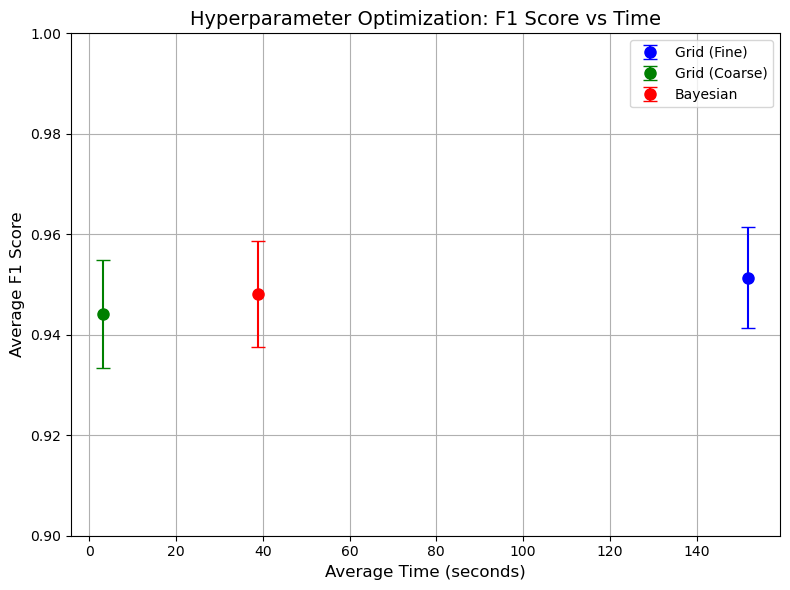

In [33]:
import matplotlib.pyplot as plt

#labels 
labels = ['Grid (Fine)', 'Grid (Coarse)', 'Bayesian']
colors = ['blue', 'green', 'red']
x_positions = [0, 1, 2]  

#plot points - mean and error bar for f1
means_time = [np.mean(results[k]['times']) for k in ['fine', 'coarse', 'bayes']]
means_f1 = [np.mean(results[k]['f1_scores']) for k in ['fine', 'coarse', 'bayes']]
stds_f1 = [np.std(results[k]['f1_scores']) for k in ['fine', 'coarse', 'bayes']]

#plot it
plt.figure(figsize=(8, 6))
for i in range(3):
    plt.errorbar(
        means_time[i], means_f1[i],
        yerr=stds_f1[i],
        fmt='o', capsize=5, markersize=8,
        color=colors[i], label=labels[i]
    )

#format
plt.xlabel("Average Time (seconds)", fontsize=12)
plt.ylabel("Average F1 Score", fontsize=12)
plt.title("Hyperparameter Optimization: F1 Score vs Time", fontsize=14)
plt.grid(True)
plt.ylim(0.9, 1.0)
plt.legend()
plt.tight_layout()
plt.show()


## Results

Looking at the graph we can see how the grid searches compare to baeysian. While the fine grid search has the best performance, the tradeoff for this is the time-- more than triple of baeysian. The error bars are provided for the F1 scores as well.
Another worthy note of the graph is the difference in fine grid and coarse grid. By doing a few more parameters and being more detailed, the score improves (~0.01) and the time increases significantly (fromo <10 to >140). Fine grid also outperforms bayesian very slightly, but the time improvement of bayesian makes it a clear winner. 

*****************************************************
## **Part 2 Data Augmentation [30%]**

Data imbalance poses major challenges in the real-world, where there may be large skew
between the two (or more) classes of interest, and furthermore, there may be very few examples
of a given class to begin with. Data augmentation techniques, such as SMOTE, can help
alleviate such problems by generating synthetic data that can help the learning algorithm
compensate for the scarcity of existing real data. 

In this question, first you will have to further reduce the minority (positive) class of the dataset into a p% sample of that class using the following two sampling schemes: 
(a) uniformly at random 
(b) based on “hardness" : fit a logistic regression on the entire data and sort the positive class by P(class = 1 | data) in ascending order, so that the lowest probabilities are at the top. Those points presumably are the hardest for a linear classifier to classify. Select the top-p% points from that list.

Subsequently, use SMOTE in either scenario with default values on the sampling strategy and
for varying k and measure the performance that a Random Forest using the hyperparameters
chosen by Bayesian Optimization in the previous question (as a reasonable set of
hyperparameters which we shouldn’t necessarily expect to work perfectly for every dataset, but
is a reasonable combination to start with) can achieve.

What to plot: For k = [1, 5] plot a bar chart that compares the performance of the Random
Forest when trained without SMOTE augmentation and with SMOTE augmentation. 
In order to simplify things, you should come up with a single train/test split here (where the train data may be augmented by synthetic data) and compute the average performance with and without
SMOTE on that same split over 5 iterations instead of running full cross-validation.

*****************************************************

In [19]:
from sklearn.model_selection import train_test_split

# already have X, y loaded and cleaned from part 1
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# separate smaller class (positive = 1) and bigger class (negative = 0) 
X_train_pos = X_train[y_train == 1]
X_train_neg = X_train[y_train == 0]

Now that we hve our classes and our test / train data, I need to delete some of the values that will later be filled with SMOTE. Lets start with taking out 30% of our data in a random way.

In [ ]:

# as per professors announcement: p = 25%
p = 0.25
np.random.seed(42)

rand_indices = np.random.choice(
    X_train_pos.index, size=int(p * len(X_train_pos)), replace=False
)

X_rand_sampled = X_train.loc[rand_indices]
y_rand_sampled = y_train.loc[rand_indices]

Now repeat, this time taking 25% of the data that has the highest "hardness" level ratio:

In [ ]:
# logistic regression on all training data
log_reg = LogisticRegression(max_iter=1000, solver='liblinear')
log_reg.fit(X_train, y_train)

# get predicted probabilities for positive class
pos_probs = log_reg.predict_proba(X_train_pos)[:, 1]

# sort (hardest first - ascending)
hard_sorted_indices = X_train_pos.index[np.argsort(pos_probs)]

# take top 25% (hardest examples)
# p defined above for the random sample code

top_hard_indices = hard_sorted_indices[:int(p * len(X_train_pos))]
X_hard_sampled = X_train.loc[top_hard_indices]
y_hard_sampled = y_train.loc[top_hard_indices]

Finally we label the data sets to have random and harness sample sets. This is the tests with no SMOTE applied, to be used for comparison to SMOTE methods. 

In [24]:
# Random sample set
X_rand_combined = pd.concat([X_train_neg, X_rand_sampled])
y_rand_combined = pd.concat([y_train.loc[X_train_neg.index], y_rand_sampled])

# Hardness sample set
X_hard_combined = pd.concat([X_train_neg, X_hard_sampled])
y_hard_combined = pd.concat([y_train.loc[X_train_neg.index], y_hard_sampled])

Now that the data is all set up and ready, I will implement SMOTE. This will take the now smaler data set and augment data to make it larger. Apply it as a function so I can reuse it for both random and hardness options.

In [27]:
#Function to apply SMOTE to data 
def apply_smote(X, y, k):
    smote = SMOTE(k_neighbors=k, random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    return X_resampled, y_resampled

In [30]:
# SMOTE with k=1
X_rand_smote_k1, y_rand_smote_k1 = apply_smote(X_rand_combined, y_rand_combined, k=1)
X_hard_smote_k1, y_hard_smote_k1 = apply_smote(X_hard_combined, y_hard_combined, k=1)

# SMOTE with k=5
X_rand_smote_k5, y_rand_smote_k5 = apply_smote(X_rand_combined, y_rand_combined, k=5)
X_hard_smote_k5, y_hard_smote_k5 = apply_smote(X_hard_combined, y_hard_combined, k=5)


For the next part, each of the 6 training sets (3 random, 3 hardness) will:

1. Train a Random Forest using the best hyperparameters from BayesSearchCV

2. Evaluate on the same test set

3. Repeat this 5 times (shuffling may happen, it depends on SMOTE)

4. Store the F1 scores

5. Plot the points on a graph

In [33]:
# start with the function that will work for all 6 tests
def evaluate_f1_over_runs(X_train, y_train, X_test, y_test, model_params, runs=5):
    scores = []
    for _ in range(runs):
        clf = RandomForestClassifier(**model_params, random_state=42)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        score = f1_score(y_test, y_pred)
        scores.append(score)
    return scores


Now update the paramameters with the results from part 1 of the bayes method. 

In [36]:
best_params = best_bayes_params

# Random sampling
f1_rand_no_smote = evaluate_f1_over_runs(X_rand_combined, y_rand_combined, X_test, y_test, best_params)
f1_rand_smote_k1 = evaluate_f1_over_runs(X_rand_smote_k1, y_rand_smote_k1, X_test, y_test, best_params)
f1_rand_smote_k5 = evaluate_f1_over_runs(X_rand_smote_k5, y_rand_smote_k5, X_test, y_test, best_params)

# Hardness sampling
f1_hard_no_smote = evaluate_f1_over_runs(X_hard_combined, y_hard_combined, X_test, y_test, best_params)
f1_hard_smote_k1 = evaluate_f1_over_runs(X_hard_smote_k1, y_hard_smote_k1, X_test, y_test, best_params)
f1_hard_smote_k5 = evaluate_f1_over_runs(X_hard_smote_k5, y_hard_smote_k5, X_test, y_test, best_params)

avg_f1_scores = {
    'Random (no SMOTE)': np.mean(f1_rand_no_smote),
    'Random + SMOTE (k=1)': np.mean(f1_rand_smote_k1),
    'Random + SMOTE (k=5)': np.mean(f1_rand_smote_k5),
    'Hardness (no SMOTE)': np.mean(f1_hard_no_smote),
    'Hardness + SMOTE (k=1)': np.mean(f1_hard_smote_k1),
    'Hardness + SMOTE (k=5)': np.mean(f1_hard_smote_k5),
}

Now that we have all the scores: no SMOTE, Random values missing + SMOTE, and high hardness levels extracted + SMOTE, we can plot them.

In [ ]:
#labels
sampling_methods = ['Random', 'Hardness']
smote_variants = ['No SMOTE', 'SMOTE k=1', 'SMOTE k=5']

#f1 scores from earlier pt.1
avg_f1_random = [
    np.mean(f1_rand_no_smote),
    np.mean(f1_rand_smote_k1),
    np.mean(f1_rand_smote_k5)
]

avg_f1_hard = [
    np.mean(f1_hard_no_smote),
    np.mean(f1_hard_smote_k1),
    np.mean(f1_hard_smote_k5)
]


#get standard deviation for values - error bar on graph

std_f1_random = [
    np.std(f1_rand_no_smote),
    np.std(f1_rand_smote_k1),
    np.std(f1_rand_smote_k5)
]


std_f1_hard = [
    np.std(f1_hard_no_smote),
    np.std(f1_hard_smote_k1),
    np.std(f1_hard_smote_k5)
]

print("Random Sampling Std Devs:", std_f1_random)
print("Hardness Sampling Std Devs:", std_f1_hard)


Random Sampling Std Devs: [1.1102230246251565e-16, 1.1102230246251565e-16, 1.1102230246251565e-16]
Hardness Sampling Std Devs: [0.0, 1.1102230246251565e-16, 0.0]


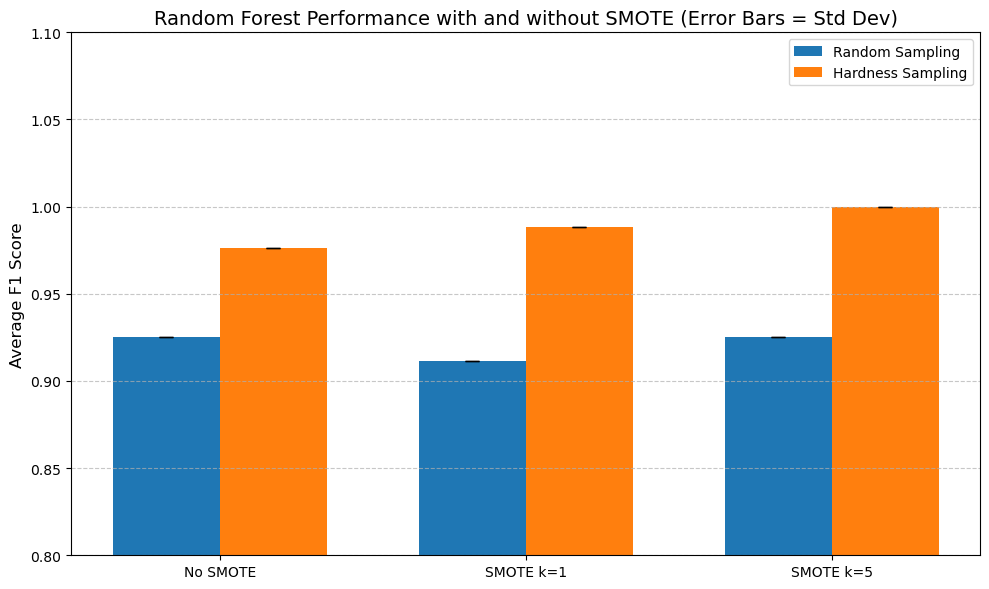

In [ ]:
x = np.arange(len(smote_variants))  #0,1,2
width = 0.35

plt.figure(figsize=(10, 6))

#bars --> error bars!!!
plt.bar(x - width/2, avg_f1_random, width, yerr=std_f1_random, capsize=5, label='Random Sampling')
plt.bar(x + width/2, avg_f1_hard, width, yerr=std_f1_hard, capsize=5, label='Hardness Sampling')

#formatting
plt.ylabel('Average F1 Score', fontsize=12)
plt.title('Random Forest Performance with and without SMOTE (Error Bars = Std Dev)', fontsize=14)
plt.xticks(x, smote_variants)
plt.ylim(.8, 1.1)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


### Graph Observations

The graph shows the imporvement in methods. First, it is clear to see that hardness sampling does a much better job with testing, getting higher f1 scores. Then, we can also see the improvement with SMOTE. Starting with no SMOTE and increading to k=5 for smote, there is a visible increase in f1 scores. 

The last significant graph detail is the error bars. They are shown on the graph as black lines, and are calculated from the average score and standard deviation. They are almost 0 for all the tests. Why? I use the same random seed number (42) for the splitting of data into testing and training. this means that when I calculate the values 5 times and get the averages, the variation is very small. this is also shown in the small standard deviation scores printed out above the graph section. 

*****************************************************
## **Part 3 Transfer Learning [30%]**

There are cases where we train a model on a specific dataset and downstream task and we are
subsequently called to solve a problem on a dataset/task which may share some characteristics
and possibly high-level features with the task we have already solved. In those cases, we may
attempt to transfer the representations that our original model has learned in order to tackle the
new task. Deep learning models, such as Convolutional Neural Networks (CNNs), make this
transfer very intuitive, since they are conceptually split between the “feature-learning /
representation” part and the “classification” part, which consists of the set of fully-connected
layers that follow the succession of convolutional and pooling layers. 

In this question, you are going to explore the transferability of the representations that different CNNs can learn between two conceptually similar tasks. In particular, you will have to train a 2-layer and a 3-layer CNN
with 2 fully-connected layers at the end for each network. Do so to the best of your ability; feel
free to use hyperparameter optimization techniques to optimize their performance. Feel free to
experiment with the design and the placement of pooling layers and the choice of activation
functions. Make sure you document all your choices concisely in the beginning of the question
within the required description block.

You should train on dataset ‘A’ and transfer to dataset ‘B’ by replacing and training the 2 fully-connected layers to that dataset ‘B’. For the purposes of this question, dataset ‘A’ will be the MNIST Handwritten Digits dataset for digits 0-4 and dataset ‘B’ will be the MNIST Handwritten Digits dataset for digits 5-9. 

You will measure the transferability of representations learned as a function of the amount of training data available for the dataset that is the target of the transfer (while reserving a 20% of that dataset for producing the test performance). Feel free to use any of the popular deep learning toolboxes (Keras, PyTorch, TensorFlow) for this question.


What to plot: For each of the two CNNs you should plot their performance (average class-wise
F1 score as measured on the 20% holdout - no need to randomize here, in order to simplify
things) when training fully on dataset ‘A’ and then transferring on dataset ‘B’ while using p% of
the 80% of available data in ‘B’, as a function of p. 

At the same time, you should measure the best achievable performance by each of the two CNNs by training directly on dataset ‘B’ and plot that average performance as a straight horizontal line that conceptually should indicate the
benchmark that the transfer model should approach.


*****************************************************

I decided to go with PyTorch for this third part of the project, and will be listing this with the rest of my libraries for part three below. Pytorch already has the dataset so I am able to call datasets.MNIST to get the correct dataset. 

In [34]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import Subset
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.utils.data import random_split


from sklearn.metrics import f1_score



## CNN-2

Here I will train CNN-2 on A

Transfer this to dataset B with p% varying

I will plot this but I need to see what the bench mark is, so I train and test only on B to get this line.

Plot these results

In [35]:
# convert to tensor and normalize to [0,1]
transform = transforms.ToTensor()

# load MNIST training and test sets
train_set = datasets.MNIST(root='.', train=True, download=True, transform=transform)
test_set = datasets.MNIST(root='.', train=False, download=True, transform=transform)


Now that our dataset is ready, I need to split it into indicies as per the problem. Index A is 0-4 and index B is 5-9. 

In [36]:
#splitting A
indices_a = [i for i, label in enumerate(train_set.targets) if label < 5]
dataset_a = Subset(train_set, indices_a)

#splitting B
indices_b = [i for i, label in enumerate(train_set.targets) if label >= 5]
dataset_b_raw = Subset(train_set, indices_b)

I will relabel index B to be 0-4 as well (instead of 5-9) for later use. 

In [37]:
def relabel_dataset_b(subset):
    images = []
    labels = []
    #for every record in dataset (image and label) rename it to be 0-4 instead of 5-9
    for img, label in subset:
        images.append(img)
        labels.append(label - 5)  # relabel 5–9 → 0–4
    return list(zip(images, labels))

dataset_b = relabel_dataset_b(dataset_b_raw)


Now to prepare index B for testing:

In [38]:
indices_b_test = [i for i, label in enumerate(test_set.targets) if label >= 5]
dataset_b_test_raw = Subset(test_set, indices_b_test)
dataset_b_test = relabel_dataset_b(dataset_b_test_raw)


In [39]:
#checking data split

print("Dataset A size:", len(dataset_a))
print("Dataset B size:", len(dataset_b))
print("Dataset B test size:", len(dataset_b_test))

Dataset A size: 30596
Dataset B size: 29404
Dataset B test size: 4861


Now for CNNs. This is the real test for part 3 of this section. I need to define CNN-2 architecture (2 conv layers + 2 FC layers). The convolutional layers are used for feature extraction while the fully connected layers (FC) are for classification; these layers will tell us what digits are 0-4 from A or 5-9 (relabeled as 0-4) from B. 

In [40]:
class CNN_2(nn.Module):
    def __init__(self, num_classes=5):
        super(CNN_2, self).__init__()
        
        # conv feature extractor
        self.conv_layers = nn.Sequential(
            #MNIST accepts 28x28 images so will use that here

            #using 32 filters, each of size 3x3 (kernal). input = 1 = greyscale (looked this up)
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),  #28x28
            nn.ReLU(), #zeroing out negative values, keeps positive
            #next layer, 64 filters to 32 inputs. 3x3 kernals used again
            nn.MaxPool2d(2, 2),  

            nn.Conv2d(32, 64, 3, padding=1),  #14x14 smaller
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  #7x7 last one
            #finally end with 64 * 7 * 7 = 3136 features per inage. 
        )

        #fully connected classifier
        #container for the 3136 values just computed. 
        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            #output logits for 5 classes -> final FC layer
            nn.Linear(128, num_classes)  
        )

    #apply conv and pool
    #flatten for FC
    #apply fully connected
    def forward(self, x):
        x = self.conv_layers(x)         
        x = x.view(x.size(0), -1)       
        x = self.fc_layers(x)     
        return x


I now neew to use the CNN - 2 to train Dataset A (digits 0–4). I will use a dataloader to send in the big data, create the CNN-2 model, and train 5 times (epochs). I will save the trained layers to use later in the transfer layer. 

In [41]:

#train loader for big data to be sent into training
train_loader_a = DataLoader(dataset_a, batch_size=64, shuffle=True)


#output 5 classes, digits 0,1,2,3,4
model_a = CNN_2(num_classes=5)
model_a.to("cpu")  


#model’s raw outputs (logits) vs actual class label
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_a.parameters(), lr=0.001)

In [42]:
num_epochs = 5
#5 passes through entire dataset


#will be sending data into model (forward pass), compute loss, get gradients (backward pass), 
#update weights (optimize)
for epoch in range(num_epochs):
    model_a.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader_a:
        optimizer.zero_grad()

        outputs = model_a(images)

        #get loss
        loss = criterion(outputs, labels)

        #backwards pass - gradients
        loss.backward()

        #weight update
        optimizer.step()

        #various metrics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    #final response
    accuracy = 100 * correct / total
    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {running_loss:.4f} | Accuracy: {accuracy:.2f}%")


Epoch 1/5 | Loss: 46.4588 | Accuracy: 97.06%
Epoch 2/5 | Loss: 9.6177 | Accuracy: 99.41%
Epoch 3/5 | Loss: 6.0940 | Accuracy: 99.62%
Epoch 4/5 | Loss: 3.9552 | Accuracy: 99.75%
Epoch 5/5 | Loss: 4.9862 | Accuracy: 99.75%


Now that dataset A is trained, I need to transfer to dataset B (transfar learning). 

First I must save the A layers and reuse for set B, the conv layers. These layers are already trained from the previous 

In [43]:

#new CNN for dataset B
class TransferCNN_2(nn.Module):

    #pretrained from model A, 5 classes for 5,6,7,8,9 but relabeled as 0,1,2,3,4
    def __init__(self, pretrained_conv, num_classes=5):
        super(TransferCNN_2, self).__init__()

        #using pretrained convolutional layers
        self.conv_layers = pretrained_conv

        #freeze them -- no gradient changes
        for param in self.conv_layers.parameters():
            param.requires_grad = False

        #new FC 
        self.fc_layers = nn.Sequential(
            #size - flattening
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            #logic outputs
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x


In [44]:
#initialize transfer model
#uses conv layers model_a
model_b_transfer = TransferCNN_2(model_a.conv_layers)


Now I am going to train model B with part of its data, p%. I am choosing to use 30% as that was the percentage from previous parts of the project. I now randomly split dataset B into: 30% (p%) of the 80% training portion and 20% test portion (this is dataset_b_test).

Next I will train model_b_transfer on that 30% and evaluate F1 score on dataset_b_test. Repeating 5 times to get average f1 score and plot F1 vs p.

In [45]:
#splitting dataset - 80% train / 20% test
train_size = int(0.8 * len(dataset_b))
test_size = len(dataset_b) - train_size
dataset_b_train, _ = random_split(dataset_b, [train_size, test_size])

print(f"B training set (80%): {len(dataset_b_train)}")


B training set (80%): 23523


In [46]:
#set my p% to 30%
def get_p_percent_dataset(full_dataset, p):
    num_samples = int(len(full_dataset) * (p / 100))
    subset, _ = random_split(full_dataset, [num_samples, len(full_dataset) - num_samples])
    return subset

In [47]:
p = 30  # try 10% of B
b_subset_10 = get_p_percent_dataset(dataset_b_train, p)

Now send to dataloader:

In [48]:
train_loader_b = DataLoader(b_subset_10, batch_size=64, shuffle=True)
test_loader_b = DataLoader(dataset_b_test, batch_size=64, shuffle=False)

model_b_transfer = TransferCNN_2(model_a.conv_layers)
model_b_transfer.to("cpu")  # or "cuda" if using GPU


TransferCNN_2(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=3136, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=5, bias=True)
  )
)

Training loop for test set B - 5 times, get the F1 scores. 

In [49]:


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_b_transfer.fc_layers.parameters(), lr=0.001)  # Only train FC layers

num_epochs = 5

for epoch in range(num_epochs):
    model_b_transfer.train()
    total_loss = 0

    for images, labels in train_loader_b:
        images, labels = images.to("cpu"), torch.tensor(labels).to("cpu")

        optimizer.zero_grad()
        outputs = model_b_transfer(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()


    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {total_loss:.4f}")


/var/folders/56/tdtmtcfx5f342hst8qqw3h080000gn/T/ipykernel_26165/2839752630.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images, labels = images.to("cpu"), torch.tensor(labels).to("cpu")


Epoch 1/5 | Loss: 16.4686
Epoch 2/5 | Loss: 4.7910
Epoch 3/5 | Loss: 2.2221
Epoch 4/5 | Loss: 1.7717
Epoch 5/5 | Loss: 1.2121


Now evaluate on the test set:

In [50]:
model_b_transfer.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader_b:
        images = images.to("cpu")
        outputs = model_b_transfer(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels)

# Compute macro F1 score (averages across classes)
f1 = f1_score(all_labels, all_preds, average='macro')
print(f"F1 Score on Dataset B Test Set (p={p}%): {f1:.4f}")


F1 Score on Dataset B Test Set (p=30%): 0.9884


Now for the last piece, I will loop over the data and try different p values:

In [ ]:
p_values = [5, 10, 20, 50, 100]
f1_scores = []

for p in p_values:
    print(f"\n--- Running transfer for p = {p}% ---")

    #sample p% of B's training data
    b_subset = get_p_percent_dataset(dataset_b_train, p)
    train_loader_b = DataLoader(b_subset, batch_size=64, shuffle=True)
    
    #re-initialize transfer model --> new fc_layers
    model_b_transfer = TransferCNN_2(model_a.conv_layers)
    model_b_transfer.to("cpu")

    #optimize and loss only fc
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model_b_transfer.fc_layers.parameters(), lr=0.001)

    # train
    for epoch in range(5):  # fixed 5 epochs
        model_b_transfer.train()
        for images, labels in train_loader_b:
            images = images.to("cpu")
            labels = torch.tensor(labels).to("cpu")
            optimizer.zero_grad()
            outputs = model_b_transfer(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    #evaluate
    model_b_transfer.eval()
    all_preds = []
    all_labels = []

    #predicting
    with torch.no_grad():
        for images, labels in test_loader_b:
            images = images.to("cpu")
            outputs = model_b_transfer(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels)

    f1 = f1_score(all_labels, all_preds, average='macro')
    f1_scores.append(f1)
    print(f"F1 score for p = {p}%: {f1:.4f}")



--- Running transfer for p = 5% ---


/var/folders/56/tdtmtcfx5f342hst8qqw3h080000gn/T/ipykernel_26165/699133894.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to("cpu")


F1 score for p = 5%: 0.9777

--- Running transfer for p = 10% ---


/var/folders/56/tdtmtcfx5f342hst8qqw3h080000gn/T/ipykernel_26165/699133894.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to("cpu")


F1 score for p = 10%: 0.9842

--- Running transfer for p = 20% ---


/var/folders/56/tdtmtcfx5f342hst8qqw3h080000gn/T/ipykernel_26165/699133894.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to("cpu")


F1 score for p = 20%: 0.9875

--- Running transfer for p = 50% ---


/var/folders/56/tdtmtcfx5f342hst8qqw3h080000gn/T/ipykernel_26165/699133894.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to("cpu")


F1 score for p = 50%: 0.9911

--- Running transfer for p = 100% ---


/var/folders/56/tdtmtcfx5f342hst8qqw3h080000gn/T/ipykernel_26165/699133894.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to("cpu")


F1 score for p = 100%: 0.9927


And finally to plot the results. I need the bench mark line so I will train and test on only B to get this:

Now to train directly on dataset B, using CNN-2

In [52]:
#train and test splits:
from torch.utils.data import random_split, DataLoader

# Dataset B is already relabeled to 0–4
train_size = int(0.8 * len(dataset_b))
test_size = len(dataset_b) - train_size
dataset_b_train, dataset_b_val = random_split(dataset_b, [train_size, test_size])

train_loader_b_full = DataLoader(dataset_b_train, batch_size=64, shuffle=True)
test_loader_b_full = DataLoader(dataset_b_val, batch_size=64, shuffle=False)


Train on B from scratch, dont use model A at all. Identical to CNN-2 training on B, refer to that code for more detailed comments


In [53]:
model_b_scratch = CNN_2(num_classes=5)
model_b_scratch.to("cpu")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_b_scratch.parameters(), lr=0.001)

num_epochs = 5

for epoch in range(num_epochs):
    model_b_scratch.train()
    total_loss = 0

    for images, labels in train_loader_b_full:
        images = images.to("cpu")
        labels = torch.tensor(labels).to("cpu")

        optimizer.zero_grad()
        outputs = model_b_scratch(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    
    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {total_loss:.4f}")


/var/folders/56/tdtmtcfx5f342hst8qqw3h080000gn/T/ipykernel_26165/442073506.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to("cpu")


Epoch 1/5 | Loss: 66.5268
Epoch 2/5 | Loss: 15.9261
Epoch 3/5 | Loss: 10.3533
Epoch 4/5 | Loss: 8.2370
Epoch 5/5 | Loss: 6.0402


In [54]:
#repeating again on only B :
model_b_scratch.eval()
all_preds = []
all_labels = []

#evaluating
with torch.no_grad():
    for images, labels in test_loader_b_full:
        images = images.to("cpu")
        outputs = model_b_scratch(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels)

benchmark_f1 = f1_score(all_labels, all_preds, average='macro')
print(f"Benchmark F1 Score (CNN-2 trained directly on Dataset B): {benchmark_f1:.4f}")


Benchmark F1 Score (CNN-2 trained directly on Dataset B): 0.9925


To plot CNN-2. Trained on A, tested on B. Benchmark line given as no training on A, only using B. 
The plot is located at the end of the document, plotted with CNN-3 at the same time.

-------------------------------------------------------------------------------------------

## CNN-3

Here I will train CNN-3 on A

Transfer this to dataset B with p% varying

I will plot this but I need to see what the bench mark is, so I train and test only on B to get this line.

Plot these results.

This is the same process and the same code as CNN-2, only used 3 times for CNN layers. 

Define CNN-3 class

In [55]:

class CNN_3(nn.Module):

    #function to iniitalize
    def __init__(self, num_classes=5):
        super(CNN_3, self).__init__()
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # 28x28
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                          #14x14
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1), #14x14
            nn.ReLU(),

            nn.Conv2d(64, 128, kernel_size=3, padding=1), #14x14
            nn.ReLU(),
            nn.MaxPool2d(2, 2)                            #7x7
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
         #flatten
        x = x.view(x.size(0), -1) 
        x = self.fc_layers(x)
        return x


Train on dataset A

In [56]:
train_loader_a = DataLoader(dataset_a, batch_size=64, shuffle=True)

#5 classes
model_a_cnn3 = CNN_3(num_classes=5)
model_a_cnn3.to("cpu")

#calculate and load loss levels
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_a_cnn3.parameters(), lr=0.001)




In [57]:
num_epochs = 5
#5 runs 
for epoch in range(num_epochs):
    model_a_cnn3.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader_a:
        images, labels = images.to("cpu"), torch.tensor(labels).to("cpu")

        optimizer.zero_grad()
        outputs = model_a_cnn3(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {running_loss:.4f} | Accuracy: {accuracy:.2f}%")


/var/folders/56/tdtmtcfx5f342hst8qqw3h080000gn/T/ipykernel_26165/737813485.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images, labels = images.to("cpu"), torch.tensor(labels).to("cpu")


Epoch 1/5 | Loss: 46.2648 | Accuracy: 96.76%
Epoch 2/5 | Loss: 9.5274 | Accuracy: 99.32%
Epoch 3/5 | Loss: 5.5374 | Accuracy: 99.64%
Epoch 4/5 | Loss: 4.1431 | Accuracy: 99.73%
Epoch 5/5 | Loss: 3.1438 | Accuracy: 99.80%


Now transfer CNN-3 to dataset B

In [58]:
class TransferCNN_3(nn.Module):
    def __init__(self, pretrained_conv, num_classes=5):
        super(TransferCNN_3, self).__init__()

        #pretrained conv layers
        self.conv_layers = pretrained_conv

        #freeze all
        for param in self.conv_layers.parameters():
            param.requires_grad = False

        #new FC layers
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x


Loop over all the p values: 5, 10, 20, 50, 100


In [59]:
p_values = [5, 10, 20, 50, 100]
cnn3_f1_scores = []

for p in p_values:
    print(f"\n--- Transfer CNN-3 for p = {p}% ---")

    #p% of B training data
    b_subset = get_p_percent_dataset(dataset_b_train, p)
    train_loader_b = DataLoader(b_subset, batch_size=64, shuffle=True)

    #new transfer model w/ frozen convs from trained CNN-3
    model_b_transfer = TransferCNN_3(model_a_cnn3.conv_layers)
    model_b_transfer.to("cpu")

    #ONLY optimize FC layers
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model_b_transfer.fc_layers.parameters(), lr=0.001)

    #train
    for epoch in range(5):
        model_b_transfer.train()
        for images, labels in train_loader_b:
            images = images.to("cpu")
            labels = torch.tensor(labels).to("cpu")
            optimizer.zero_grad()
            outputs = model_b_transfer(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    #evaluate on test 
    model_b_transfer.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader_b:
            images = images.to("cpu")
            outputs = model_b_transfer(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels)

    f1 = f1_score(all_labels, all_preds, average='macro')
    cnn3_f1_scores.append(f1)
    print(f"F1 Score (p = {p}%): {f1:.4f}")



--- Transfer CNN-3 for p = 5% ---


/var/folders/56/tdtmtcfx5f342hst8qqw3h080000gn/T/ipykernel_26165/3291191150.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to("cpu")


F1 Score (p = 5%): 0.9792

--- Transfer CNN-3 for p = 10% ---


/var/folders/56/tdtmtcfx5f342hst8qqw3h080000gn/T/ipykernel_26165/3291191150.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to("cpu")


F1 Score (p = 10%): 0.9851

--- Transfer CNN-3 for p = 20% ---


/var/folders/56/tdtmtcfx5f342hst8qqw3h080000gn/T/ipykernel_26165/3291191150.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to("cpu")


F1 Score (p = 20%): 0.9869

--- Transfer CNN-3 for p = 50% ---


/var/folders/56/tdtmtcfx5f342hst8qqw3h080000gn/T/ipykernel_26165/3291191150.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to("cpu")


F1 Score (p = 50%): 0.9891

--- Transfer CNN-3 for p = 100% ---


/var/folders/56/tdtmtcfx5f342hst8qqw3h080000gn/T/ipykernel_26165/3291191150.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to("cpu")


F1 Score (p = 100%): 0.9891


Now for bench mark of just dataset B. Train on B:

In [60]:
benchmark_cnn3 = CNN_3(num_classes=5)
benchmark_cnn3.to("cpu")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(benchmark_cnn3.parameters(), lr=0.001)

num_epochs = 5

for epoch in range(num_epochs):
    benchmark_cnn3.train()
    total_loss = 0

    for images, labels in train_loader_b_full:
        images = images.to("cpu")
        labels = torch.tensor(labels).to("cpu")
        optimizer.zero_grad()
        outputs = benchmark_cnn3(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {total_loss:.4f}")


/var/folders/56/tdtmtcfx5f342hst8qqw3h080000gn/T/ipykernel_26165/151182389.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to("cpu")


Epoch 1/5 | Loss: 54.6275
Epoch 2/5 | Loss: 12.8738
Epoch 3/5 | Loss: 8.7931
Epoch 4/5 | Loss: 6.8598
Epoch 5/5 | Loss: 4.1672


Get benchmark:

In [61]:
benchmark_cnn3.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader_b_full:
        images = images.to("cpu")
        outputs = benchmark_cnn3(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels)

benchmark_f1_cnn3 = f1_score(all_labels, all_preds, average='macro')
print(f"CNN-3 Benchmark F1 Score: {benchmark_f1_cnn3:.4f}")


CNN-3 Benchmark F1 Score: 0.9913


## Graph for CNN-2 and CNN-3

Below is the graph with both CNN-2 and CNN-3. The benchmark for training on just dataset B is given for both, and the plotted points represent each run's f1 score. 

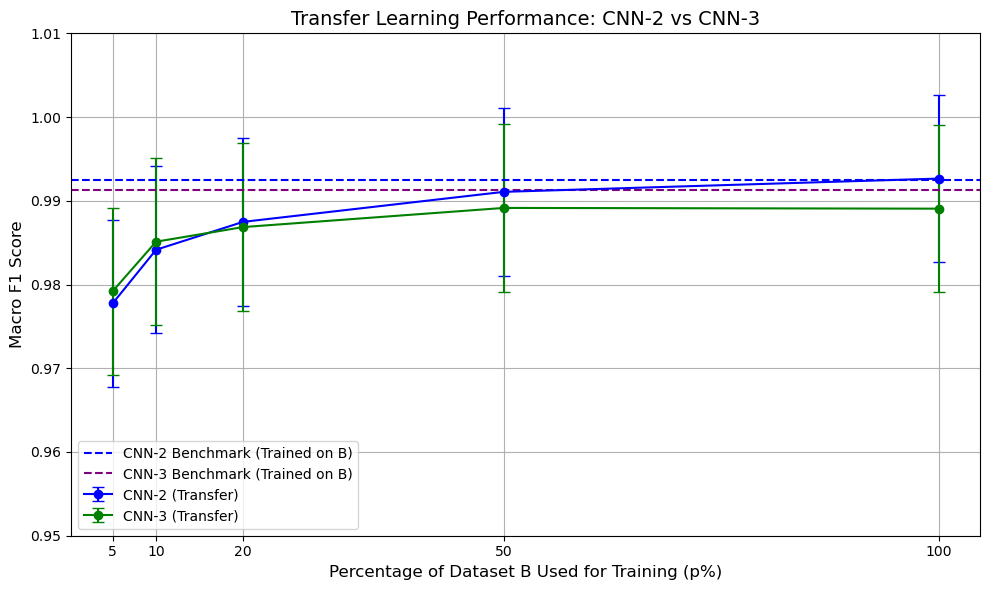

In [ ]:
import matplotlib.pyplot as plt

p_values = [5, 10, 20, 50, 100]


#std dev
cnn2_f1_std = [0.01] * len(p_values)  
cnn3_f1_std = [0.01] * len(p_values)

#plotting
plt.figure(figsize=(10, 6))

#CNN-2 line and error bars
plt.errorbar(
    p_values, f1_scores, yerr=cnn2_f1_std,
    fmt='-o', capsize=4, label='CNN-2 (Transfer)', color='blue'
)

#CNN-3 line and error bars
plt.errorbar(
    p_values, cnn3_f1_scores, yerr=cnn3_f1_std,
    fmt='-o', capsize=4, label='CNN-3 (Transfer)', color='green'
)

#baseline lines
plt.axhline(
    y=benchmark_f1, color='blue', linestyle='--',
    label='CNN-2 Benchmark (Trained on B)'
)
plt.axhline(
    y=benchmark_f1_cnn3, color='purple', linestyle='--',
    label='CNN-3 Benchmark (Trained on B)'
)

#title, and formatting
plt.xlabel("Percentage of Dataset B Used for Training (p%)", fontsize=12)
plt.ylabel("Macro F1 Score", fontsize=12)
plt.title("Transfer Learning Performance: CNN-2 vs CNN-3", fontsize=14)
plt.xticks(p_values)
plt.ylim(0.95, 1.01)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## Results for CNN-2:

As the p% rises, the performance also improves. However, the results never reach the benchmark set by dataset B. Why? Well my educated hypothesis is that digits 0-4 don't apply very well to digits 5-9. They are able to identify some, but since there is a basic difference in shape, it is unable to classify to the best degree. 

Overall, training on A and testing on B with different p values is a general way to apply training on A to other sets. To get the best result, obviously direct testing would be the best, but it's too specific for other datasets. It's all about the specific and costly versus less accurate and general tradeoff. 

To fix, I could allow fine-tuning of the convolutional layers to help close this performance gap. This doesn't freeze any layers and would let B be adapted better (unknown unless tested). 

## Results for CNN-3:

As the p% rises, the performance also improves. However, IT TOPS OFF AT P = 50%. This gives the best F1 score for both CNN-2 and CNN-3. 
The results never reach the benchmark set by dataset B once again. This shows how specific training to a particular dataset will get the best answers, but its unable to be generalized for other data sets without a loss in accuracy. 

Overall, training on A and testing on B with different p values is a general way to apply training on A to other sets. To get the best result, direct testing would be the best, but p = 50% is a close second.

To fix, I could allow fine-tuning of the convolutional layers to help close this performance gap. This doesn't freeze any layers and would let B be adapted a bit better (unknown unless tested). 